In [1]:
from db_connection import create_connection, query_data, query_sql_file, select_table
from preprocessing import process_admissions, process_patients, process_transfers, apply_feature_importance


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to the MIMIC-III database
con = create_connection()

# Admissions

In [4]:
admissions = select_table('admissions', con)
print(admissions.head())

   row_id  subject_id  hadm_id           admittime           dischtime  \
0      21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1      22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2      23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3      24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4      25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   

  deathtime admission_type         admission_location  \
0       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location insurance language           religion  \
0  DISC-TRAN CANCER/CHLDRN H   Private     None       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare     None           CATHOLIC   
2 

In [5]:
print(admissions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                58976 non-null  int64         
 1   subject_id            58976 non-null  int64         
 2   hadm_id               58976 non-null  int64         
 3   admittime             58976 non-null  datetime64[ns]
 4   dischtime             58976 non-null  datetime64[ns]
 5   deathtime             5854 non-null   datetime64[ns]
 6   admission_type        58976 non-null  object        
 7   admission_location    58976 non-null  object        
 8   discharge_location    58976 non-null  object        
 9   insurance             58976 non-null  object        
 10  language              33644 non-null  object        
 11  religion              58518 non-null  object        
 12  marital_status        48848 non-null  object        
 13  ethnicity       

In [6]:
# check null values
print(admissions.isnull().sum())

row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64


In [7]:
# check admission locations
print(admissions.admission_location.value_counts())

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: admission_location, dtype: int64


In [8]:
# check admission type
print(admissions.admission_type.value_counts())

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64


In [9]:
admissions = process_admissions.group_admission_type(admissions)
print(admissions.admission_type.value_counts())

EMERGENCY    43407
NEWBORN       7863
ELECTIVE      7706
Name: admission_type, dtype: int64


In [10]:
# check demographics
print(admissions.ethnicity.unique())

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'MULTI RACE ETHNICITY'
 'BLACK/AFRICAN AMERICAN' 'HISPANIC OR LATINO'
 'PATIENT DECLINED TO ANSWER' 'ASIAN' 'OTHER'
 'HISPANIC/LATINO - GUATEMALAN' 'ASIAN - VIETNAMESE'
 'AMERICAN INDIAN/ALASKA NATIVE' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - CHINESE' 'ASIAN - ASIAN INDIAN'
 'BLACK/AFRICAN' 'HISPANIC/LATINO - SALVADORAN'
 'HISPANIC/LATINO - DOMINICAN' 'UNABLE TO OBTAIN' 'BLACK/CAPE VERDEAN'
 'BLACK/HAITIAN' 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'SOUTH AMERICAN'
 'WHITE - EASTERN EUROPEAN' 'CARIBBEAN ISLAND' 'ASIAN - FILIPINO'
 'ASIAN - CAMBODIAN' 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)'
 'WHITE - BRAZILIAN' 'ASIAN - KOREAN' 'HISPANIC/LATINO - COLOMBIAN'
 'ASIAN - JAPANESE' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'ASIAN - THAI' 'HISPANIC/LATINO - HONDURAN' 'HISPANIC/LATINO - CUBAN'
 'MIDDLE EASTERN' 'ASIAN - OTHER' 'HISPANIC/LATINO - MEXICAN'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']


In [11]:
# grouping similar categories
admissions = process_admissions.group_ethnicities(admissions)
print(admissions.ethnicity.value_counts())

WHITE                   41386
OTHER/UNKNOWN            7408
BLACK                    5785
HISPANIC/LATINO          2128
ASIAN                    2050
MULTI RACE ETHNICITY      130
NATIVE AMERICAN            54
ISLANDER                   35
Name: ethnicity, dtype: int64


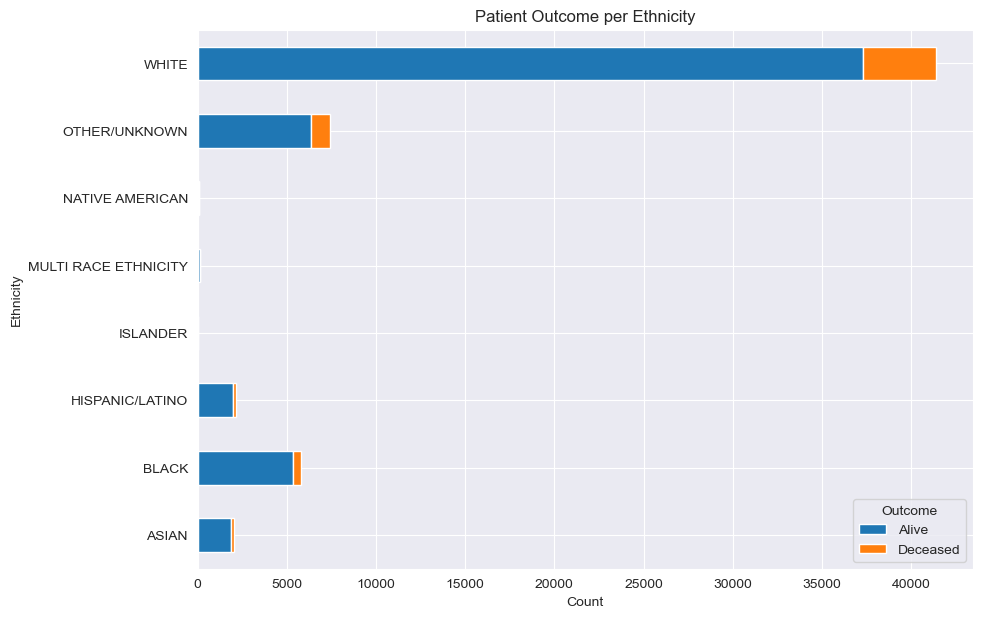

In [12]:
outcome_counts = admissions.groupby(['ethnicity', 'hospital_expire_flag']).size().unstack()
outcome_counts.plot(kind='barh', stacked=True, figsize=(10, 7))

plt.title('Patient Outcome per Ethnicity')
plt.ylabel('Ethnicity')
plt.xlabel('Count')
plt.legend(title='Outcome', labels=['Alive', 'Deceased'])

plt.show()

In [13]:
cross_tab_script = '../sql_scripts/admissions_cross_tab.sql'
query_list = query_sql_file(cross_tab_script, con)

admission_locations = query_data(query_list[0], con)
admission_types = query_data(query_list[1], con)

pivot_table = query_data(query_list[2], con)
print(pivot_table)

          Admission Location ELECTIVE EMERGENCY/URGENT NEWBORN
0   ** INFO NOT AVAILABLE **     None                5     199
1  CLINIC REFERRAL/PREMATURE       25            10002    1987
2       EMERGENCY ROOM ADMIT     None            22754    None
3          HMO REFERRAL/SICK     None                1     101
4  PHYS REFERRAL/NORMAL DELI     7646             1432    5553
5  TRANSFER FROM HOSP/EXTRAM       19              849      23
6  TRANSFER FROM OTHER HEALT        3                7    None
7  TRANSFER FROM SKILLED NUR       13               14    None
8  TRSF WITHIN THIS FACILITY     None                5    None


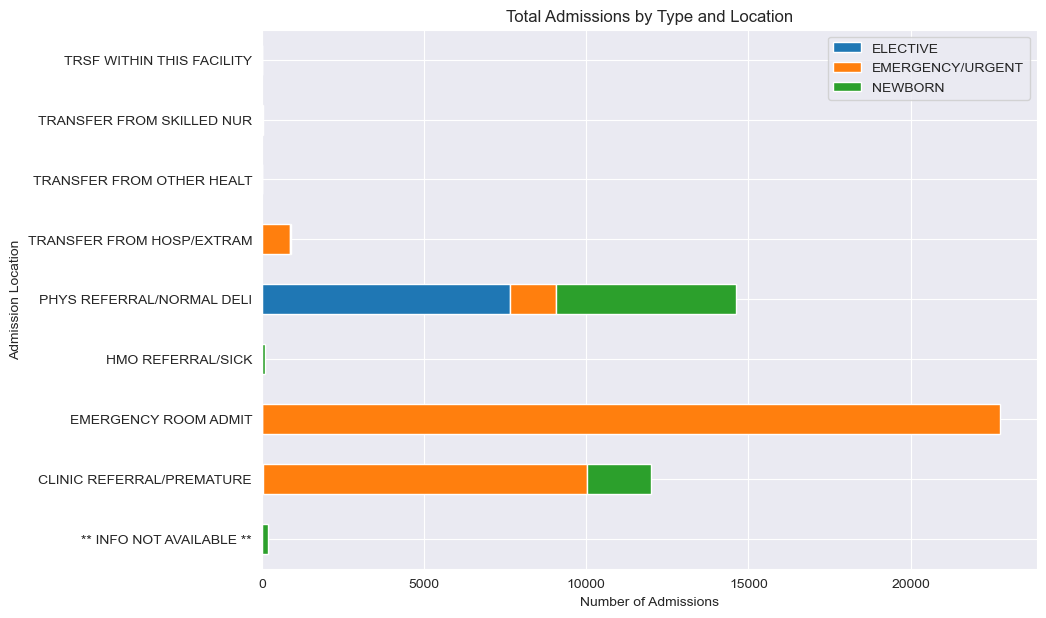

In [14]:
pivot_table.fillna(0, inplace=True)
pivot_table.set_index('Admission Location', inplace=True)

for col in ['ELECTIVE', 'EMERGENCY/URGENT', 'NEWBORN']:
    pivot_table[col] = pivot_table[col].astype(int)

pivot_table.plot(kind='barh', stacked=True, figsize=(10, 7))

plt.xlabel('Number of Admissions')
plt.title('Total Admissions by Type and Location')
plt.show()

In [15]:
# check preliminary diagnosis
print(admissions.diagnosis.unique())

['BENZODIAZEPINE OVERDOSE'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA' 'BRAIN MASS'
 ... 'R/O METASTASIS'
 'GASTROPARESIS\\PLACEMENT OF G-TUBE **REMOTE WEST**/SDA' 'JOINT EFFUSION']


# Patients

In [16]:
patients = select_table('patients', con)
print(patients.head())

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag  
0            0  
1            1  
2            0  
3            0  
4            0  


In [17]:
print(patients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   row_id       46520 non-null  int64         
 1   subject_id   46520 non-null  int64         
 2   gender       46520 non-null  object        
 3   dob          46520 non-null  datetime64[ns]
 4   dod          15759 non-null  datetime64[ns]
 5   dod_hosp     9974 non-null   datetime64[ns]
 6   dod_ssn      13378 non-null  datetime64[ns]
 7   expire_flag  46520 non-null  int64         
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 2.8+ MB
None


In [18]:
# Adding patients first admission time
patients = process_patients.add_first_admission(patients, admissions)
print(patients.head())

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag first_admittime  
0            0      2149-12-17  
1            1      2188-11-12  
2            0      2110-07-27  
3            0      2133-03-31  
4            0      2174-01-21  


In [19]:
print(patients.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46520 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   row_id           46520 non-null  int64         
 1   subject_id       46520 non-null  int64         
 2   gender           46520 non-null  object        
 3   dob              46520 non-null  datetime64[ns]
 4   dod              15759 non-null  datetime64[ns]
 5   dod_hosp         9974 non-null   datetime64[ns]
 6   dod_ssn          13378 non-null  datetime64[ns]
 7   expire_flag      46520 non-null  int64         
 8   first_admittime  46520 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(3), object(1)
memory usage: 3.5+ MB
None


In [20]:
# Calculating real age at first admission time
patients = process_patients.calc_age_at_admission(patients)
print(patients.head())

patients = patients.drop(columns=['first_admittime'])

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag first_admittime  age_at_admission  
0            0      2149-12-17                74  
1            1      2188-11-12                24  
2            0      2110-07-27                20  
3            0      2133-03-31                55  
4            0      2174-01-21                85  


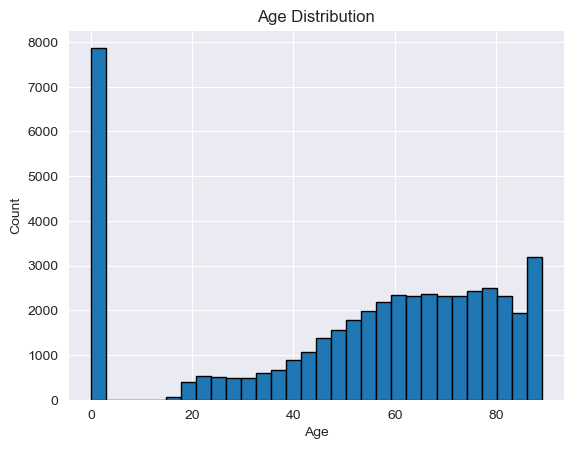

In [21]:
# Visualizing age distribution in patients table
plt.hist(patients['age_at_admission'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [22]:
print(patients.age_at_admission.median())
print(patients.age_at_admission.mean())

60.0
52.84765692175409


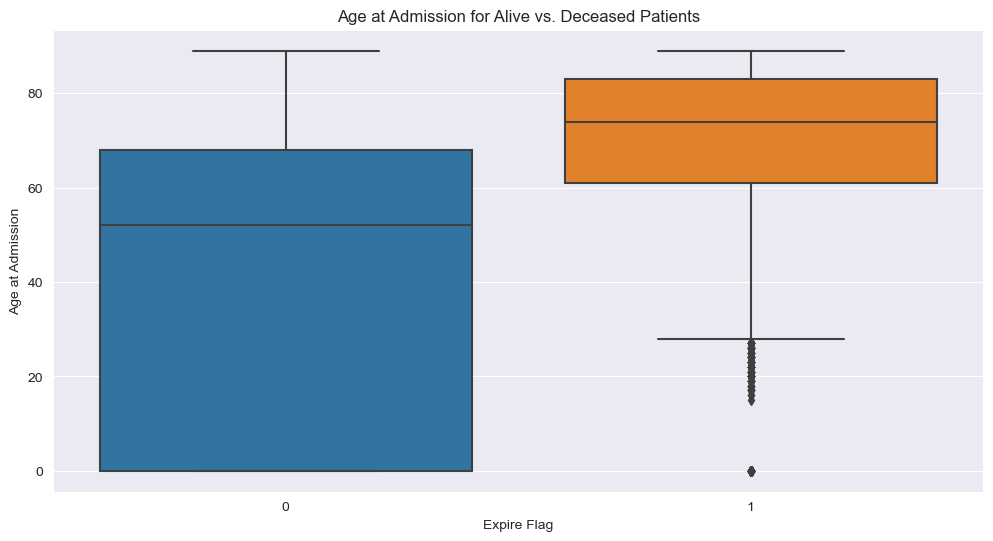

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='expire_flag', y='age_at_admission', data=patients)
plt.xlabel('Expire Flag')
plt.ylabel('Age at Admission')
plt.title('Age at Admission for Alive vs. Deceased Patients')
plt.show()


Text(0.5, 1.0, 'Gender Distribution')

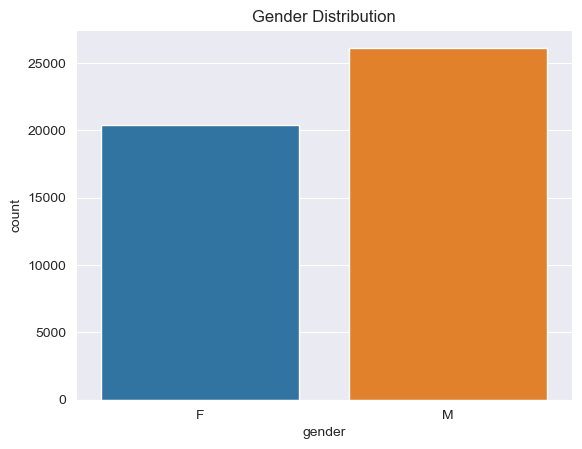

In [24]:
sns.countplot(data=patients, x='gender')
plt.title('Gender Distribution')

In [25]:
# Find the patients that died in the hospital
deceased_subject_ids = admissions.subject_id[admissions.hospital_expire_flag == 1].tolist()
deceased_patients_in = patients[patients.subject_id.isin(deceased_subject_ids)]

# Find the patients that died outside the hospital
deceased_patients_out = patients[(patients.expire_flag == 1) & (~patients.subject_id.isin(deceased_subject_ids))]

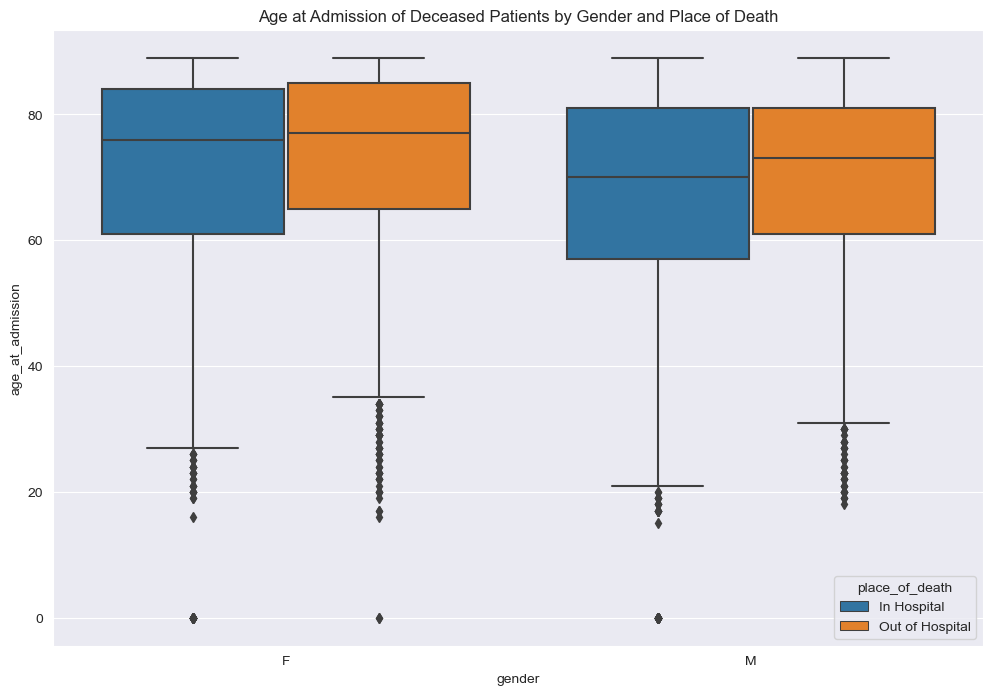

In [26]:
deceased_patients_in['place_of_death'] = 'In Hospital'
deceased_patients_out['place_of_death'] = 'Out of Hospital'
deceased_patients = pd.concat([deceased_patients_in, deceased_patients_out])

plt.figure(figsize=(12,8))
sns.boxplot(x='gender', y='age_at_admission', hue='place_of_death', data=deceased_patients)
plt.title('Age at Admission of Deceased Patients by Gender and Place of Death')
plt.show()

# ICUSTAYS

In [27]:
icustays = select_table('icustays', con)
print(icustays.head())

   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2198-02-14 23:27:38   
1          MICU            52           52 2170-11-05 11:05:29   
2           CCU            57           57 2128-06-24 15:05:20   
3          SICU            52           23 2120-08-07 23:12:42   
4           CCU            57           57 2186-12-25 21:08:04   

              outtime     los  
0 2198-02-18 05:26:11  3.2490  
1 2170-11-08 17:46:57  3.2788  
2 2128-06-27 12:32:29  2.8939  
3 2120-08-10 00:39:04  2.0600  
4 2186-12-27 12:01:13 

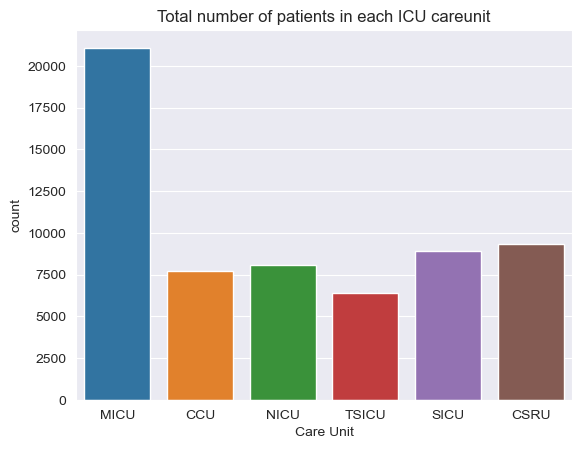

In [28]:
sns.countplot(data=icustays, x='first_careunit')
plt.title('Total number of patients in each ICU careunit')
plt.xlabel('Care Unit')
plt.show()

   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2198-02-14 23:27:38   
1          MICU            52           52 2170-11-05 11:05:29   
2           CCU            57           57 2128-06-24 15:05:20   
3          SICU            52           23 2120-08-07 23:12:42   
4           CCU            57           57 2186-12-25 21:08:04   

              outtime     los  hospital_expire_flag  
0 2198-02-18 05:26:11  3.2490                     1  
1 2170-11-08 17:46:57  3.2788                     0  
2 2128-06-27 12:32:2

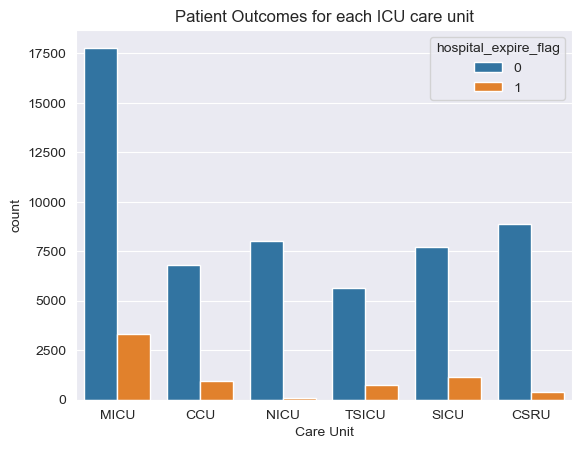

In [29]:
df = pd.merge(icustays, admissions[['hadm_id', 'subject_id', 'hospital_expire_flag']], on=['hadm_id', 'subject_id'], how='left')
print(df.head())
sns.countplot(data=df, x='first_careunit', hue='hospital_expire_flag')
plt.title('Patient Outcomes for each ICU care unit')
plt.xlabel('Care Unit')
plt.show()

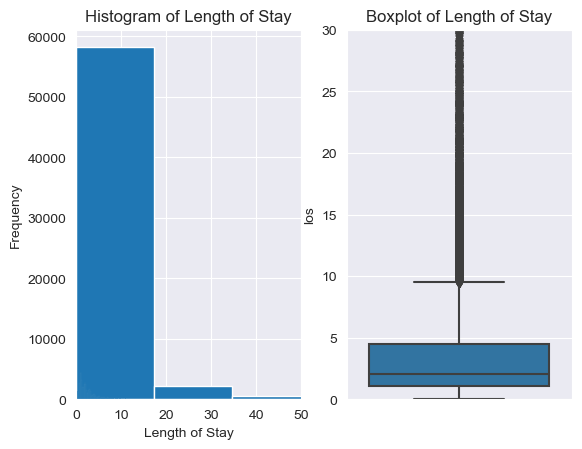

In [30]:
plt.subplot(1, 2, 1)
icustays.los.plot(kind='hist')
sns.histplot(data=icustays, x='los')

plt.xlim(0, 50)
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Stay')

plt.subplot(1, 2, 2)
sns.boxplot(data=icustays, y='los')
plt.ylim(0, 30)
plt.title('Boxplot of Length of Stay')

plt.show()

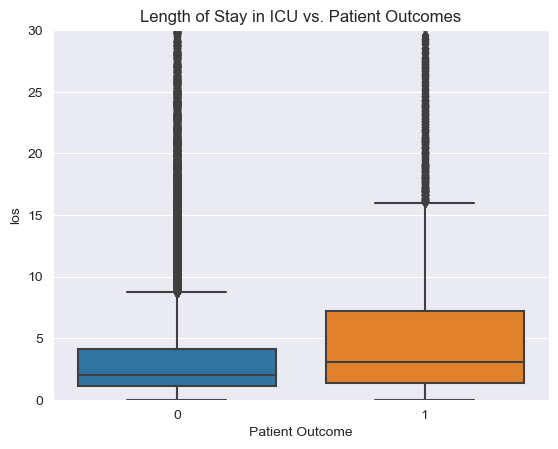

In [31]:
sns.boxplot(data=df, x='hospital_expire_flag', y='los')
plt.ylim(0, 30)
plt.title('Length of Stay in ICU vs. Patient Outcomes')
plt.xlabel('Patient Outcome')
plt.show()

# TRANSFERS

In [32]:
query = \
"""
SELECT a.hadm_id, t.hadm_id AS t_hadm_id
FROM admissions AS a
LEFT JOIN transfers AS t
ON a.hadm_id = t.hadm_id;
"""

result = query_data(query, con)
missing_services = result[result['t_hadm_id'].isnull()]

print(f"Number of missing HADM_IDs in transfers: {len(missing_services)}")

Number of missing HADM_IDs in transfers: 0


In [33]:
# Calculate the Total Length of Stay for each admission - includes ADMISSION, TRANSFER, and DISCHARGE
query = \
"""
SELECT hadm_id, SUM(los) as total_los
FROM transfers
GROUP BY hadm_id;
"""
transfers = query_data(query, con)
print(transfers.head())

   hadm_id  total_los
0   155703     262.73
1   130406     349.57
2   194150     120.18
3   117336      20.81
4   167276     673.05


In [34]:
# Only keep relevant features on the final version of the dataframes
admissions = process_admissions.clean_df(admissions)
patients = process_patients.clean_df(patients)
icustays = process_transfers.clean_icu(icustays)

In [35]:
admissions.head()

,subject_id,hadm_id,admission_type,admission_location,ethnicity,diagnosis,hospital_expire_flag
0,22,165315,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,BENZODIAZEPINE OVERDOSE,0
1,23,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0
2,23,124321,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,BRAIN MASS,0
3,24,161859,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,WHITE,INTERIOR MYOCARDIAL INFARCTION,0
4,25,129635,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,ACUTE CORONARY SYNDROME,0


In [36]:
patients.head()

,subject_id,gender,expire_flag,age_at_admission
0,249,F,0,74
1,250,F,1,24
2,251,M,0,20
3,252,M,0,55
4,253,F,0,85


In [37]:
icustays.head()

,hadm_id,icustay_id,first_careunit,icu_los
0,110404,280836,MICU,3.2490
1,106296,206613,MICU,3.2788
2,188028,220345,CCU,2.8939
3,173727,249196,MICU,2.0600
4,164716,210407,CCU,1.6202


In [38]:
df = pd.merge(admissions, patients, on='subject_id', how='left')
df = pd.merge(df, transfers, on='hadm_id', how='left')
df = pd.merge(df, icustays, on='hadm_id', how='left')
print(df.head())

   subject_id  hadm_id admission_type         admission_location ethnicity  \
0          22   165315      EMERGENCY       EMERGENCY ROOM ADMIT     WHITE   
1          23   152223       ELECTIVE  PHYS REFERRAL/NORMAL DELI     WHITE   
2          23   124321      EMERGENCY  TRANSFER FROM HOSP/EXTRAM     WHITE   
3          24   161859      EMERGENCY  TRANSFER FROM HOSP/EXTRAM     WHITE   
4          25   129635      EMERGENCY       EMERGENCY ROOM ADMIT     WHITE   

                                           diagnosis  hospital_expire_flag  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

  gender  expire_flag  age_at_admission  total_los  icustay_id

In [39]:
# Save the dataframe into a csv file to access it during model training
df.to_csv('../dataset/patient_stay_data.csv', index=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62722 entries, 0 to 62721
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            62722 non-null  int64  
 1   hadm_id               62722 non-null  int64  
 2   admission_type        62722 non-null  object 
 3   admission_location    62722 non-null  object 
 4   ethnicity             62722 non-null  object 
 5   diagnosis             62697 non-null  object 
 6   hospital_expire_flag  62722 non-null  int64  
 7   gender                62722 non-null  object 
 8   expire_flag           62722 non-null  int64  
 9   age_at_admission      62722 non-null  int64  
 10  total_los             62691 non-null  float64
 11  icustay_id            61532 non-null  float64
 12  first_careunit        61532 non-null  object 
 13  icu_los               61522 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 7.2+ MB


## Feature Importance

In [41]:
# Encoding Categorical and Numerical Features
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
ohe = OneHotEncoder()

# For binary variables - LabelEncoder
df['gender'] = le.fit_transform(df['gender']) # Male and Female can be represented as 0 and 1

# For nominal variables - OneHotEncoder
nominal_features = ['admission_type', 'admission_location', 'ethnicity', 'first_careunit']
for feature in nominal_features:
    encoded_features = ohe.fit_transform(df[feature].values.reshape(-1, 1)).toarray()
    feature_labels = ohe.categories_
    encoded_labels = [f'{feature}_{label}' for label in feature_labels[0]]
    df_encoded = pd.DataFrame(encoded_features, columns=encoded_labels)
    df = pd.concat([df, df_encoded], axis=1)


# For numerical features -ld handle missing values
df['total_los'].fillna(0, inplace=True)
df['icu_los'].fillna(0, inplace=True)

df.drop(columns=nominal_features + ['gender'], inplace=True)
df.drop(columns=['hadm_id', 'subject_id', 'icustay_id', 'diagnosis', 'hospital_expire_flag'], inplace=True)

In [42]:
print(df.head())

   expire_flag  age_at_admission  total_los  icu_los  admission_type_ELECTIVE  \
0            0                65      27.45   1.1438                      0.0   
1            0                71     138.78   1.2641                      1.0   
2            0                71     162.48   1.1862                      0.0   
3            0                39      68.52   0.5124                      0.0   
4            0                59      86.28   3.5466                      0.0   

   admission_type_EMERGENCY  admission_type_NEWBORN  \
0                       1.0                     0.0   
1                       0.0                     0.0   
2                       1.0                     0.0   
3                       1.0                     0.0   
4                       1.0                     0.0   

   admission_location_** INFO NOT AVAILABLE **  \
0                                          0.0   
1                                          0.0   
2                               

In [43]:
# Applying Feature Importance using Random Forest
rf_importance, rf_accuracies = apply_feature_importance.get_feature_importance(df=df, classifier='rf')

for feature, importance in rf_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: total_los, Importance: 0.2867454924559159
Feature: icu_los, Importance: 0.265358391997298
Feature: age_at_admission, Importance: 0.2643137259990276
Feature: first_careunit_NICU, Importance: 0.020791094840742243
Feature: admission_type_NEWBORN, Importance: 0.019156732692909493
Feature: admission_location_EMERGENCY ROOM ADMIT, Importance: 0.01833828745182163
Feature: first_careunit_MICU, Importance: 0.015792945083840965
Feature: admission_type_EMERGENCY, Importance: 0.015174121110253163
Feature: first_careunit_CSRU, Importance: 0.013677833793783739
Feature: admission_location_CLINIC REFERRAL/PREMATURE, Importance: 0.011510630012759178
Feature: admission_location_PHYS REFERRAL/NORMAL DELI, Importance: 0.009470109181900936
Feature: ethnicity_WHITE, Importance: 0.007382558646579929
Feature: first_careunit_TSICU, Importance: 0.006898418278963209
Feature: ethnicity_OTHER/UNKNOWN, Importance: 0.005953352524193154
Feature: first_careunit_SICU, Importance: 0.005590995908161104
Feature: 

In [44]:
for acc_type, value in rf_accuracies.items():
    print(f"{acc_type}: {value}")

Accuracy: 0.7294467768507201
Precision: 0.6653020892151327
Recall: 0.634064307816494
F1 Score: 0.6493077082041744
AUC-ROC: 0.7128947681036089


In [45]:
xgb_importance, xgb_accuracies = apply_feature_importance.get_feature_importance(df=df, classifier='xgb')

for feature, importance in xgb_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: first_careunit_CSRU, Importance: 0.2205989956855774
Feature: age_at_admission, Importance: 0.14074744284152985
Feature: admission_location_EMERGENCY ROOM ADMIT, Importance: 0.10519678890705109
Feature: first_careunit_MICU, Importance: 0.06763971596956253
Feature: admission_location_CLINIC REFERRAL/PREMATURE, Importance: 0.05695921182632446
Feature: admission_type_ELECTIVE, Importance: 0.05426078289747238
Feature: admission_location_TRANSFER FROM SKILLED NUR, Importance: 0.04730738699436188
Feature: first_careunit_TSICU, Importance: 0.037648994475603104
Feature: total_los, Importance: 0.025334076955914497
Feature: first_careunit_CCU, Importance: 0.024970369413495064
Feature: ethnicity_HISPANIC/LATINO, Importance: 0.024228734895586967
Feature: ethnicity_BLACK, Importance: 0.023455629125237465
Feature: icu_los, Importance: 0.02205333113670349
Feature: ethnicity_OTHER/UNKNOWN, Importance: 0.018148472532629967
Feature: ethnicity_ASIAN, Importance: 0.01792043074965477
Feature: admis

In [46]:
for acc_type, value in xgb_accuracies.items():
    print(f"{acc_type}: {value}")

Accuracy: 0.7451772333528193
Precision: 0.6896204715353651
Recall: 0.6453652630162787
F1 Score: 0.6667593300437834
AUC-ROC: 0.7278565598285891


In [47]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['expire_flag'])
y = df['expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

kbest = SelectKBest(score_func=chi2, k=10)

fit = kbest.fit(X, y)

# Get the scores associated with each feature
np.set_printoptions(precision=3)
print(fit.scores_)

X_new = fit.transform(X)

mask = kbest.get_support()
new_features = [] # The list of the K best features

for bool, feature in zip(mask, X.columns):
    if bool:
        new_features.append(feature)
print(new_features)

[1.446e+05 2.507e+05 5.656e+01 3.336e+02 1.353e+03 4.978e+03 1.157e+02
 5.394e+02 2.061e+03 5.451e+01 2.294e+03 2.392e+02 2.701e+01 1.932e+02
 3.256e+00 1.891e+02 1.500e+01 1.706e+02 7.814e+00 2.501e+01 3.083e+00
 4.138e+00 4.866e+01 3.548e+02 5.122e+02 1.929e+03 5.055e+03 1.075e+02
 5.257e+01 1.964e+01]
['age_at_admission', 'total_los', 'admission_type_EMERGENCY', 'admission_type_NEWBORN', 'admission_location_CLINIC REFERRAL/PREMATURE', 'admission_location_EMERGENCY ROOM ADMIT', 'admission_location_PHYS REFERRAL/NORMAL DELI', 'first_careunit_CSRU', 'first_careunit_MICU', 'first_careunit_NICU']
